## Quantum Autoencoder with MNIST classification

### Can fewer neurons achive the same goal generated by larger ones?


A quantum autoencoder (QAE) applies the same principle of a classical autoencoder.  
However, instead of neurons, statevector is applied.  

A quantum state autoencoder is a circuit that takes a statevector as input. That is a "encoder". 
The encoder outputs a reduced version of that statevector, which corresponds to latent vector in a classical AE.  

In order to obtain the original statevector (approximately) from the encoded
statevector, we can apply the opposite of a encoder circuit. That is a "decoder".

A QAE is composed of the encoder and decoder. 
In near-term quantum computing, i.e., NISQ device may not allow us to use a lot of computing resources. Therefore, QAE can be useful for reducing the use of these resources.

![fig1](./fig1.png)

As you can see in the above figure, we have a $4\times 4$ statevector that we want to encode into a $2\times 2$ statevector. We can do this by applying autoencoder to our circuit.

The general process to construct a QAE:
- Generate a statevector that we want to reduce
- Create an ansatz for a set of parameters
- Create the decoder by finding the inverse of the AutoEncoder ansatz
- Get the cost the AutoEncoder by comparing the original state with the restored state from the Decoder
- Optimize the parameters by using a classical optimization routine

In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter, ParameterVector

#import MNIST set 
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

2022-10-20 20:17:13.168396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nishida/software/hdf5.1.8.12/lib:/home/nishida/software/fftw/lib:/home/nishida/software/libvdwxc/lib:/home/nishida/software/libxc/lib:/usr/local/lib:
2022-10-20 20:17:13.168419: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Statevector generation
A quantum circuit initialize the data.  
MNIST has ten classes representing integer values from 0 to 9. 
In this notebook, only 0 and 1 is classified, the others are filtered. 
Given that pixel values go from 0 to 255, we normalize them to get [0,1].

In [2]:
# loading the MNIST set divided by a train set and a test
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# rescale the images from [0,255] to the [0,1] range
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [4]:
# showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 60000
Number of images in the test set: 10000


In [5]:
# Function to filter the 0 and 1 labels of the MNIST set
'''
Input  : x_label and y_label sets
Output : x_label and y_label sets filterd

'''
def filter_01(x,y):
    keep = (y==0)|(y==1)  # OR
    x, y = x[keep], y[keep]
    return x,y

In [6]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

In [7]:
# showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 12665
Number of images in the test set: 2115


/tmp/ipykernel_62223/183765521.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


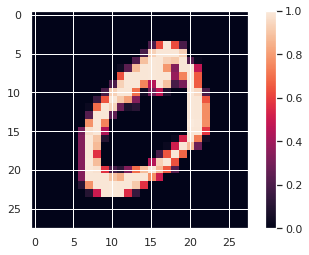

In [8]:
# plotting the first element of the train set
plt.imshow(x_train[0,:,:,0])
plt.colorbar()

### Image resizing

Tensorflow has the function tf.image.resize that decrease the images by the following possible methods
- bilinear
- lanczos3
- lanczos5
- bicubic
- gaussian
- nearest (nearest neighbor interpolation)
- area
- mitchellcubic

In [9]:
# resizing the image from 28x28 to 8x8 by the nearest method

x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

2022-10-20 20:17:16.752252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nishida/software/hdf5.1.8.12/lib:/home/nishida/software/fftw/lib:/home/nishida/software/libvdwxc/lib:/home/nishida/software/libxc/lib:/usr/local/lib:
2022-10-20 20:17:16.752274: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-20 20:17:16.752292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leaf): /proc/driver/nvidia/version does not exist
2022-10-20 20:17:16.753709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

/tmp/ipykernel_62223/3898902645.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


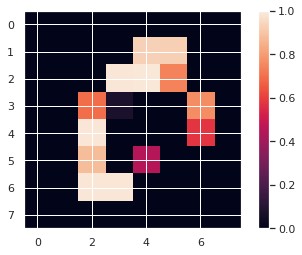

In [10]:
# plotting the first element of the train set after the resizing
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [11]:
x_train_small.shape

(12665, 8, 8, 1)

In [12]:
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)

In [13]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.93333333, 0.92941176, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98823529,
       0.99215686, 0.74117647, 0.        , 0.        , 0.        ,
       0.        , 0.69803922, 0.0745098 , 0.        , 0.        ,
       0.76470588, 0.        , 0.        , 0.        , 0.98823529,
       0.        , 0.        , 0.        , 0.58039216, 0.        ,
       0.        , 0.        , 0.88235294, 0.        , 0.44705882,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.98823529, 0.98823529, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

#### Transforming into qubits
Eight options are set.

- The first 5 images of the training set.
- The first 10 images of the training set.
- The first 12 images of the training set.
- The first 50 images of the training set.
- The first 70 images of the training set.
- The first 100 images of the training set.
- The first 200 images of the training set.
- The first 500 images of the training set.

In [14]:
x_train = (x_train)
x_test = (x_test)

# deleting no valuable information for the training set
k = 0 
while k < len(x_train):
    a = x_train[k].copy() # make a copy of the actual element
    # verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_train[k])
        x_train = np.delete(x_train, k, axis=0) # delete the actual element from the x_label
        y_train = np.delete(y_train, k, axis=0) # delete the actual element from the y_label
        k -= 1 # take back one value of the counter to match the new set length
    k+=1

In [15]:
# deleting no valuable information for the test set
k = 0
while k < len(x_test): #Deleting no valuable information for the training set
    a = x_test[k].copy()
    #Verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_test[k])
        x_test = np.delete(x_test, k, axis=0) #Delete the actual element from the x_label
        y_test = np.delete(y_test, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

In [16]:
k

2115

These data are renormalized and defined a vector state and then apply it to our quantum circuit model.

In [17]:
import cmath
# Function to normalize the data of an array
'''
Input : Array with n values
Output : Array with normalized valued
'''

def Normalize(row):
    suma = np.sqrt(np.sum(row**2))
    if suma==0:
        return 0.0
    row = row/suma
    return row

for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])
    
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])
    

### Construction of the QAE
- For this part 6 qubits are considered, since $64 = 2^6$.
- The amplitude method is applied just with 1 layer.

In [18]:
n = 6
num_layers = 1
# making a ndarray of floats based on the number of layers
params = np.random.random(10*(num_layers))

In [19]:
# showing the normalized values of the first element of the training set
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30173661, 0.30046881, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31948582,
       0.32075362, 0.23961437, 0.        , 0.        , 0.        ,
       0.        , 0.22566856, 0.02408822, 0.        , 0.        ,
       0.24722117, 0.        , 0.        , 0.        , 0.31948582,
       0.        , 0.        , 0.        , 0.18763453, 0.        ,
       0.        , 0.        , 0.2852552 , 0.        , 0.1445293 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.31948582, 0.31948582, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [20]:
# function to create a quantum circuit based on the number of qubit
# and a vector of complex amplitudes to initialize to
'''
Input : Number of qubits, vector of complex amplitudes
Output : Qunatum Circuit
'''
def input_data(n, inputs):
    circuit = QuantumCircuit(n,1)
    circuit.initialize(inputs, range(0,n,1))
    circuit.barrier()
    return circuit

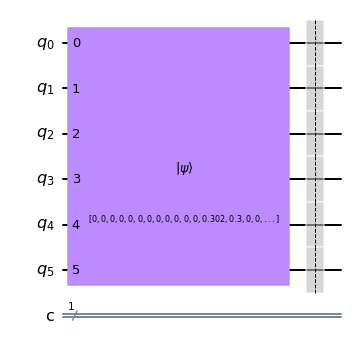

In [21]:
input_data(n,x_train[0]).draw('mpl')

In [22]:
# function to create a quantum variational circuit
'''
Input : number of qubits, number of layers, parameters to initialzied the circuit
Output : Quantum circuit
'''
def vqc(n, num_layers, params):
    parameters = ParameterVector('Θ',10*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n,1)
    
    #creating the circuit for each layer
    for layer in range(num_layers):
        for i in range(n):
            circuit.ry(parameters[(layer)+i],i)
        circuit.barrier()
    
        circuit.cx(2,0)
        circuit.cx(3,1)
        circuit.cx(5,4)
        circuit.barrier()
    
        circuit.ry(parameters[6+(layer)],0)
        circuit.ry(parameters[7+(layer)],1)
        circuit.ry(parameters[8+(layer)],4)
        circuit.barrier()
    
        circuit.cx(4,1)
        circuit.barrier()
    
        circuit.ry(parameters[9+(layer)],1) 
        circuit.barrier()    

    params_dict = {}
    i=0
    for p in parameters:
        params_dict[p] = params[i]
        i += 1        
        
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

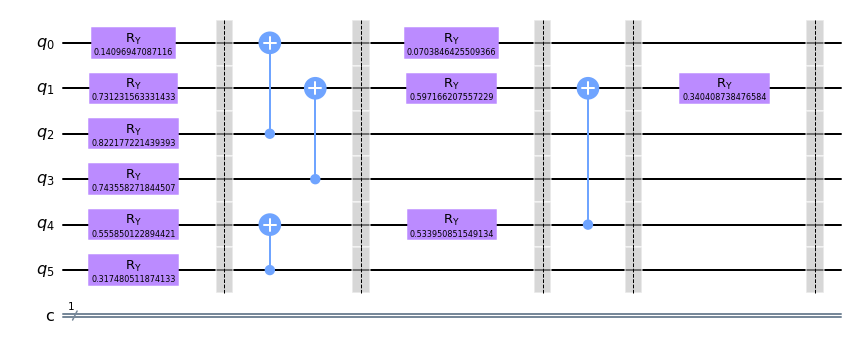

In [23]:
# an example with 6 qubits, 1-layer and 10 parameters
vqc(n, num_layers, params).draw('mpl')

In [24]:
# fucntion to make a swap test
'''
Input: Number of qubits
Output: Quantum circuit
'''
def swap_test(n):
    qubits_values = 2*n+1 
    qc = QuantumCircuit(qubits_values) 
    qc.h(0)
    for i in range(n):
    # applying a cswap gate between the first quibit and the i+1 and 2*n-i qubits
    #   qc.cswap(0,i+1,2*n-i)
       qc.cswap(0,i+1,i+1+n)        
    qc.h(0)
    qc.barrier()
    return qc

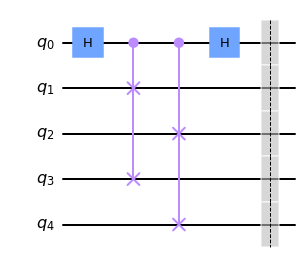

In [25]:
# example of a swap test with 2 quibits
swap_test(2).draw(output="mpl")

The circuit of the autoencoder to encode 6 qubits into 4 qubitshe circuit of the autoencoder to encode 6 qubits into 4 qubits.

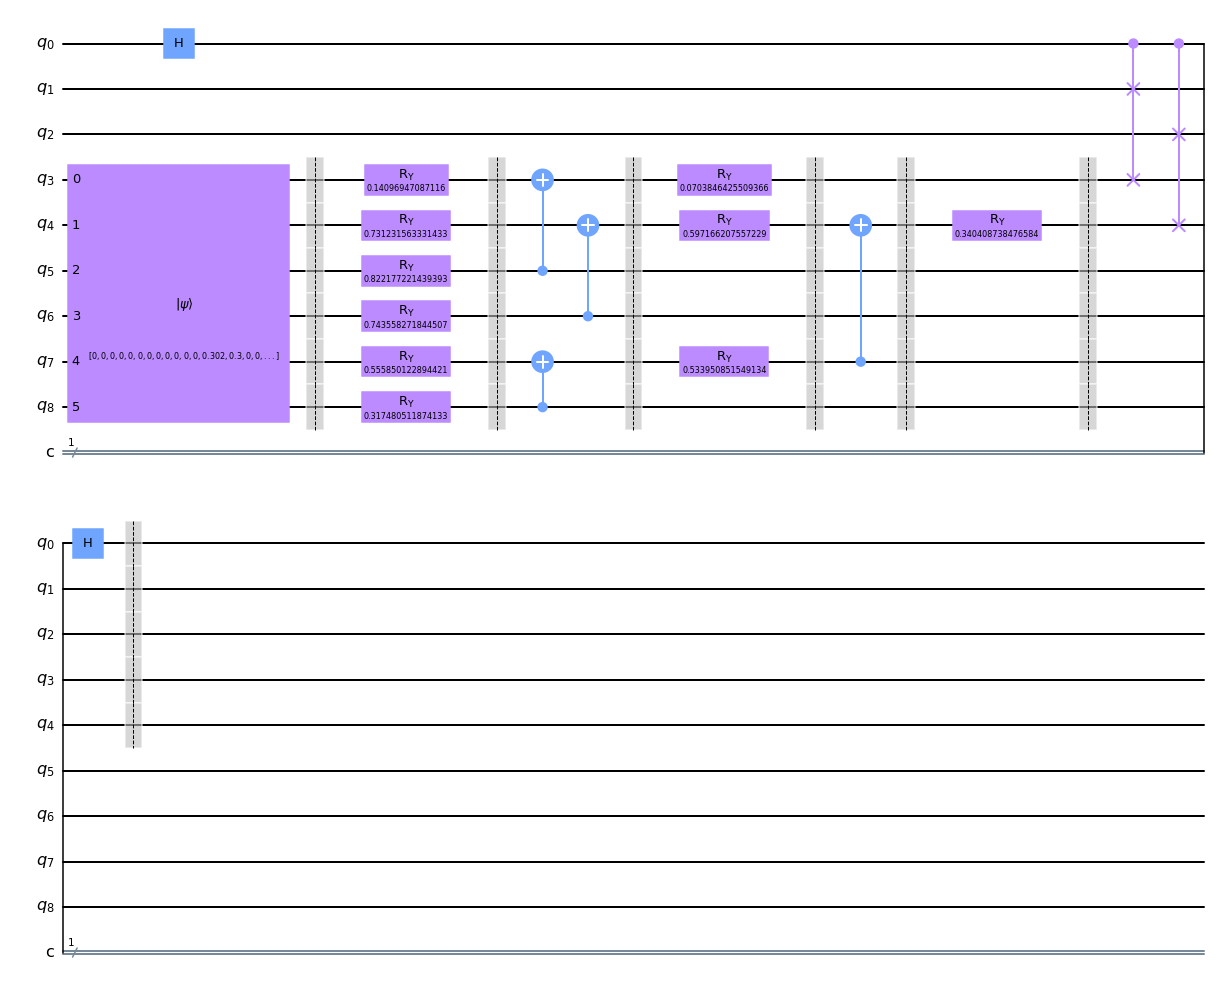

In [26]:
size_reduce = 2 # number of qubits we want to reduce
circuit_init = input_data(n,x_train[0]) # initial circuit
circuit_vqc = vqc(n,num_layers,params) # pqc
circuit_swap_test = swap_test(size_reduce) # swap test, product

# full circuit
circuit_full = QuantumCircuit(n+size_reduce+1,1)
circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

## Decoder

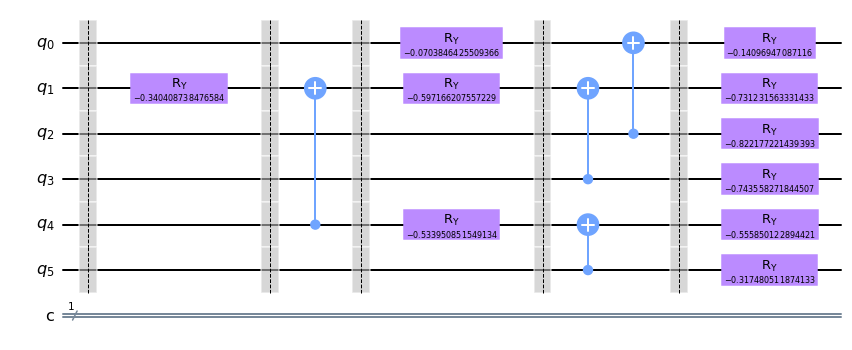

In [27]:
# generate the inverse of the QVC
vqc(n,num_layers,params).inverse().draw(output = "mpl")

## Optimization

Now, QAE is constructed. Let's optimize the circuit. 

In [28]:
from random import shuffle
from scipy.optimize import minimize

Now, to identify the cost we used the expected value of the z-axis,

$$\langle Z\rangle =\langle q| Z|q\rangle =\langle q|0\rangle 
\langle 0|q\rangle - \langle q|1\rangle \langle 1|q\rangle
= |\langle 0|q\rangle |^2- |\langle 1|q\rangle |^2
$$

After integrating the swap-test criteria,

$$
1-\langle Z\rangle = 1-  |\langle 0|q\rangle |^2+ |\langle 1|q\rangle |^2
$$

In [29]:
# function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''
def cost_function(params):
    cost = 0
    shuffle(x_train) # shuflle training data
    length = 5 # first five elements of the taining set
    
    for i in range(length):
        
        circuit_init = input_data(n,x_train[i])# initial circuit
        circuit_vqc = vqc(n,num_layers,params) # pqc
        circuit_swap_test = swap_test(size_reduce) # inner product
        
        # full circuit
        circuit_full = QuantumCircuit(n+size_reduce+1,1)
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0) # measure the first qubit
        
        shots= 8192 
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=shots )
        counts = job.result().get_counts() 
        probs = {} 
        
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots #Calculate the average of a state
            else:
                probs[output] = 0
        cost = cost + (1 + probs['1'] - probs['0']) # 1-<Z>
    return cost/length

In [30]:
for i in range(1):
    minimum = minimize(cost_function, params, method='COBYLA', tol=1e-6)
    params = minimum.x 
    
    print(" cost: ",cost_function(params))
    print(params)

 cost:  0.289501953125
[ 0.47348901  0.21742254  0.2964333   1.5592424   1.81433458  0.02045672
 -1.596047    0.38316366 -0.12805616 -0.19313344]


## Compress test set

In [31]:
print(len(x_test))
print(params)

2115
[ 0.47348901  0.21742254  0.2964333   1.5592424   1.81433458  0.02045672
 -1.596047    0.38316366 -0.12805616 -0.19313344]


In [32]:
def compress_result_test(params):
    reduce = [] 

    for i in range(30):
        circuit_init = input_data(n,x_test[i]) 
        circuit_vqc = vqc(n,num_layers,params)
        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) 
        
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts() 
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs) 
        
    return reduce

In [33]:
reduce_img =compress_result_test(params)
test_reduce = [] 

for i in reduce_img:
    index_image = [] 
    for j in range(16):
        bin_index = bin(j)[2:] 
        while len(bin_index) <4: # bin_index is less than 4
            bin_index = '0'+bin_index # concatenate a 0 string at the beginnig
        try:
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
    test_reduce.append(np.array(index_image))

In [34]:
#Function to compress the training set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_train(params):
    reduce = [] 
    for i in range(30):
        circuit_init = input_data(n,x_train[i])
        circuit_vqc = vqc(n,num_layers,params) 
        circuit_full = QuantumCircuit(n,n-size_reduce)

        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) 
        
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i)
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=8192 )
        result = job.result().get_counts() 
        probs = {k: np.sqrt(v / 8192) for k, v in result.items()}
        reduce.append(probs) 
    return reduce
        
reduce_img =compress_result_train(params)
train_reduce = [] 
for i in reduce_img:
    index_image = [] 

    # 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:  
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
            
    #We save the new imagen values in the train_recuce list
    train_reduce.append(np.array(index_image))

<Figure size 432x288 with 0 Axes>

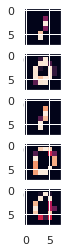

In [35]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_test[0].reshape(8,8)*255)
axarr[1].imshow(x_test[1].reshape(8,8)*255)
axarr[2].imshow(x_test[2].reshape(8,8)*255)
axarr[3].imshow(x_test[3].reshape(8,8)*255)
axarr[4].imshow(x_test[4].reshape(8,8)*255)

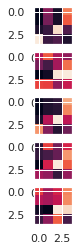

In [36]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(test_reduce[0].reshape(4,4)*255)
axarr[1].imshow(test_reduce[1].reshape(4,4)*255)
axarr[2].imshow(test_reduce[2].reshape(4,4)*255)
axarr[3].imshow(test_reduce[3].reshape(4,4)*255)
axarr[4].imshow(test_reduce[4].reshape(4,4)*255)

## Data decompression

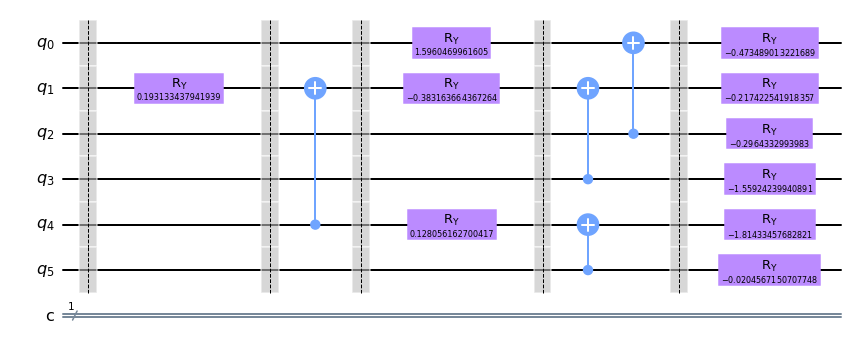

In [37]:
vqc(n,num_layers,params).inverse().draw(output = "mpl")

In [38]:
def decoder_result_test(params):
    reduce = [] 
    
    for i in range(30):
        circuit_init = input_data(6,np.concatenate((np.zeros(48), test_reduce[i]), axis=0)) 
        circuit_vqc = vqc(n,num_layers,params).inverse()
        circuit_full = QuantumCircuit(n,n)
        
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])

        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() 
        reduce.append(result)
    return reduce
        
decoder = decoder_result_test(params)

/tmp/ipykernel_62223/1441296641.py:7: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
/tmp/ipykernel_62223/1441296641.py:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
/tmp/ipykernel_62223/1441296641.py:9: DeprecationWarning: The return type of saved statevector

<Figure size 432x288 with 0 Axes>

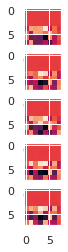

In [39]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
axarr[2].imshow(decoder[2].real.reshape(8,8)*255)
axarr[3].imshow(decoder[3].real.reshape(8,8)*255)
axarr[4].imshow(decoder[4].real.reshape(8,8)*255)

In [40]:
import qiskit.tools.jupyter
%qiskit_version_table